<span style="color: #e63946; font-family: 'Georgia', serif; font-size: 50px;">
Image Registration is a method to align multiple images to ensure the spatial correspondence of anatomy across different images.
</span>

Regions with similar intensity patterns correspond to the same anatomical structures.

    - White matter has consistent intensity

    - Cortex has consistent intensity

    - Ventricles have consistent intensity

## From the paper methods 4/20

<span style="color: #e63946; font-family: 'Calibri', serif; font-size: 22px;">
....."The electrodes had 4 mm diameter (2.3
mm exposed), 1 cm inter-electrode distance, and were embedded in silastic. Electrode locations
relative to gyral surface anatomy were determined by projection of the post-implant CT to the
pre-operative axial T1 using normalized mutual information in SPM, and the CTMR package,
with Freesurfer-extracted cortical surface mesh reconstructions [25–28]. When the MRI or CT
was of insufficient quality, hybrid techniques were used"
</span>





AI slop:

<span style="color: #e6399e; font-family: 'Calibri', serif; font-size: 22px;">
What does “normalized mutual information” imply?

Normalized mutual information is a similarity metric used for multi-modal RIGID or AFFINE registration.

CT and MRI have completely different intensity distributions.
You cannot use simple correlation.
You must use mutual information.

In SPM, when they say “using normalized mutual information,” that means:

-   They used SPM’s coregistration routine, which is:

-   6-parameter rigid transform (default)

-   Optional 12-parameter affine

-   NOT nonlinear warping

-   Rigid body transform (rotation + translation only)

Why rigid is sufficient:

-   CT and MRI of the same person:

    -   Same skull

    -   Same brain

    -   Same geometry

The only difference is:

-   Head position in scanner

-   Coordinate system origin

So you only need:

-  3 rotations

-   3 translations

You do NOT want nonlinear warping here — that would distort electrode geometry.
</span>

In [1]:
## check to see if the MRI is already transformed:

import nibabel as nib

img = nib.load("/Users/rustin/Documents/Big Data 567/faces_basic/brains/aa/aa_mri.nii")
print(img.shape)
print(img.header.get_zooms())
print(img.affine)


(256, 256, 124)
(1.01562, 1.01562, 1.5)
[[-1.00720489e+00  1.02754518e-01 -1.18741348e-01  1.28363373e+02]
 [ 9.85665098e-02  1.00931907e+00  8.14803690e-02 -1.48515945e+02]
 [-8.54802579e-02 -4.69090044e-02  1.49307120e+00 -6.99965820e+01]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]


<span style="color: #67e639; font-family: 'Georgia', serif; font-size: 22px;">
# MNI152



-   Young adults

-   Typically reported range:

    -   18–43 years

-   Mean ≈ mid-20s to early-30s (varies slightly by report)
Approximately equal male and female representation

-   Roughly 70–80 males and 70–80 females

-   Neurologically healthy

-   No known psychiatric disorders

-   No major structural abnormalities

-   The templates for image intensity (T1, T2,PD) and tissue type (GM, WM, CSF) 

</span>

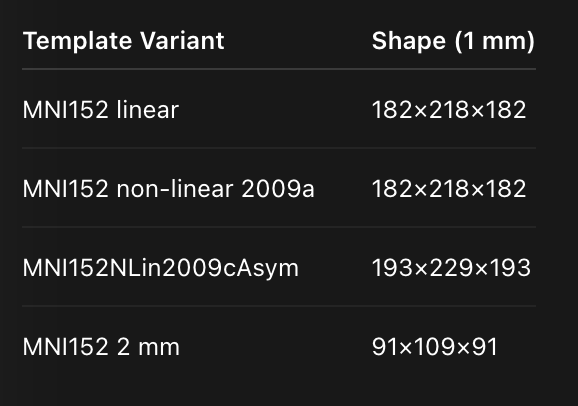

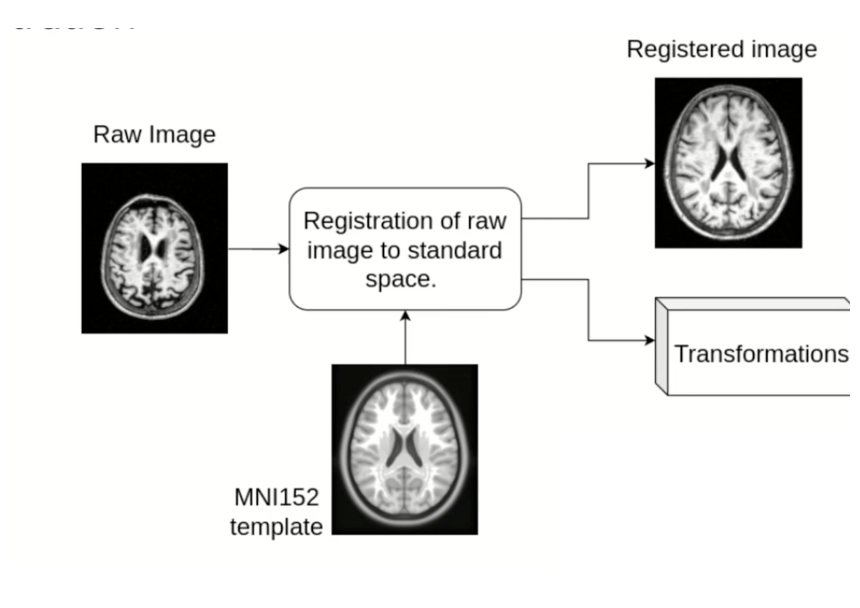

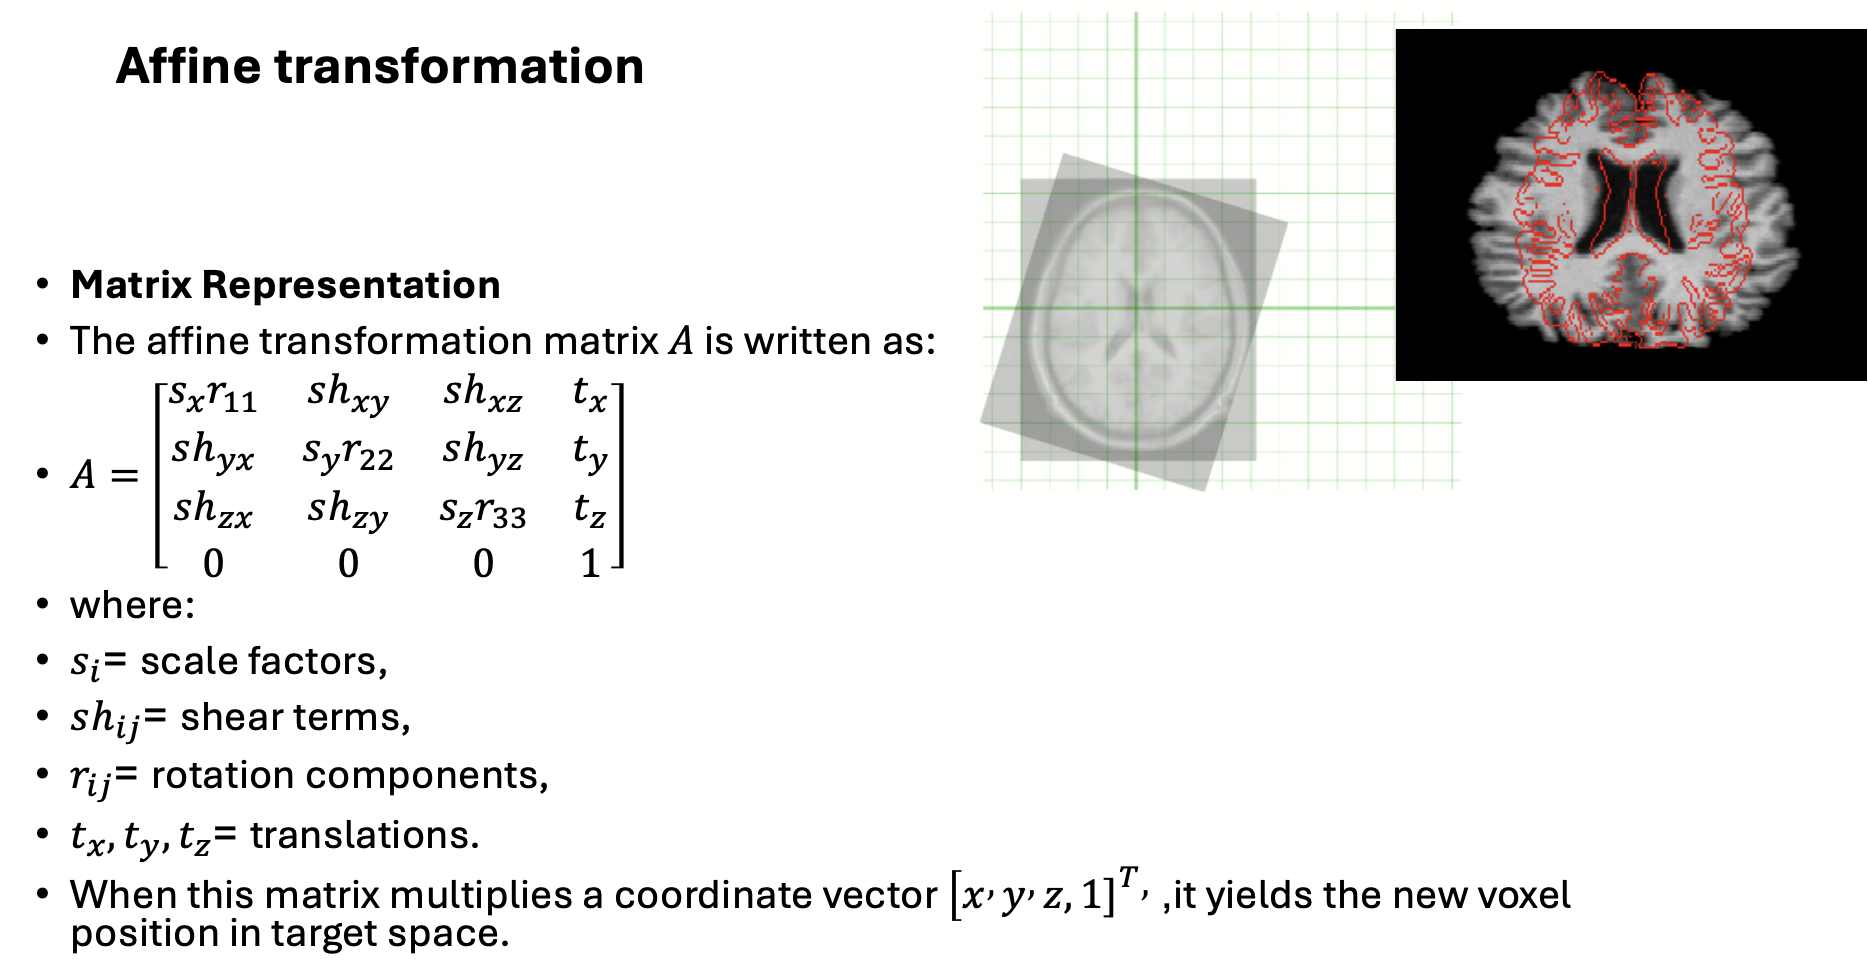

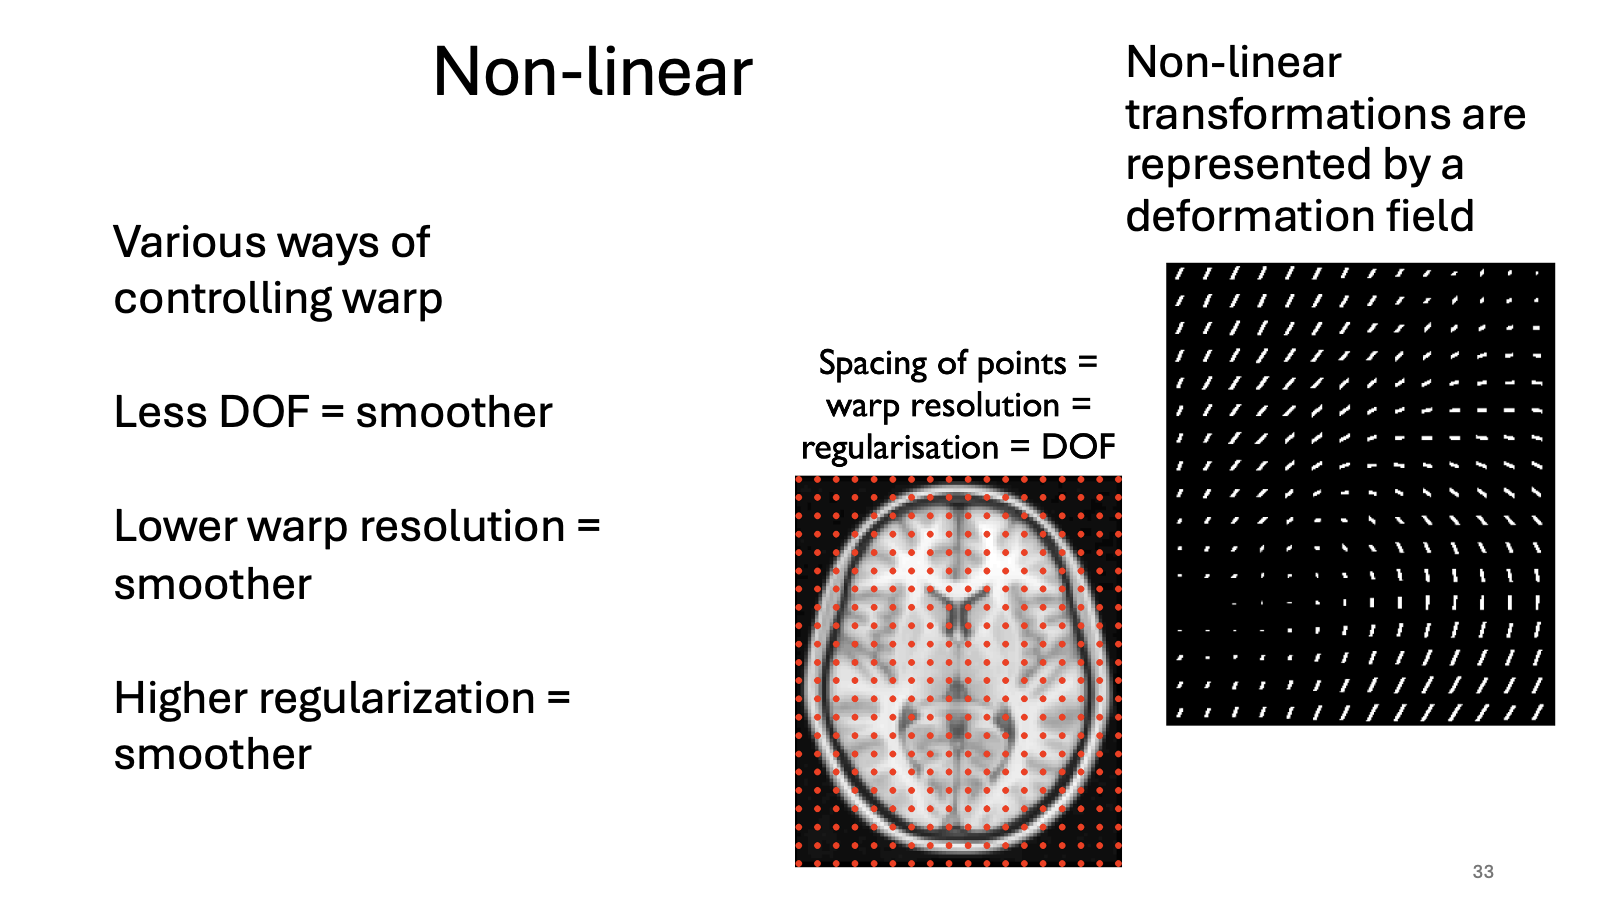

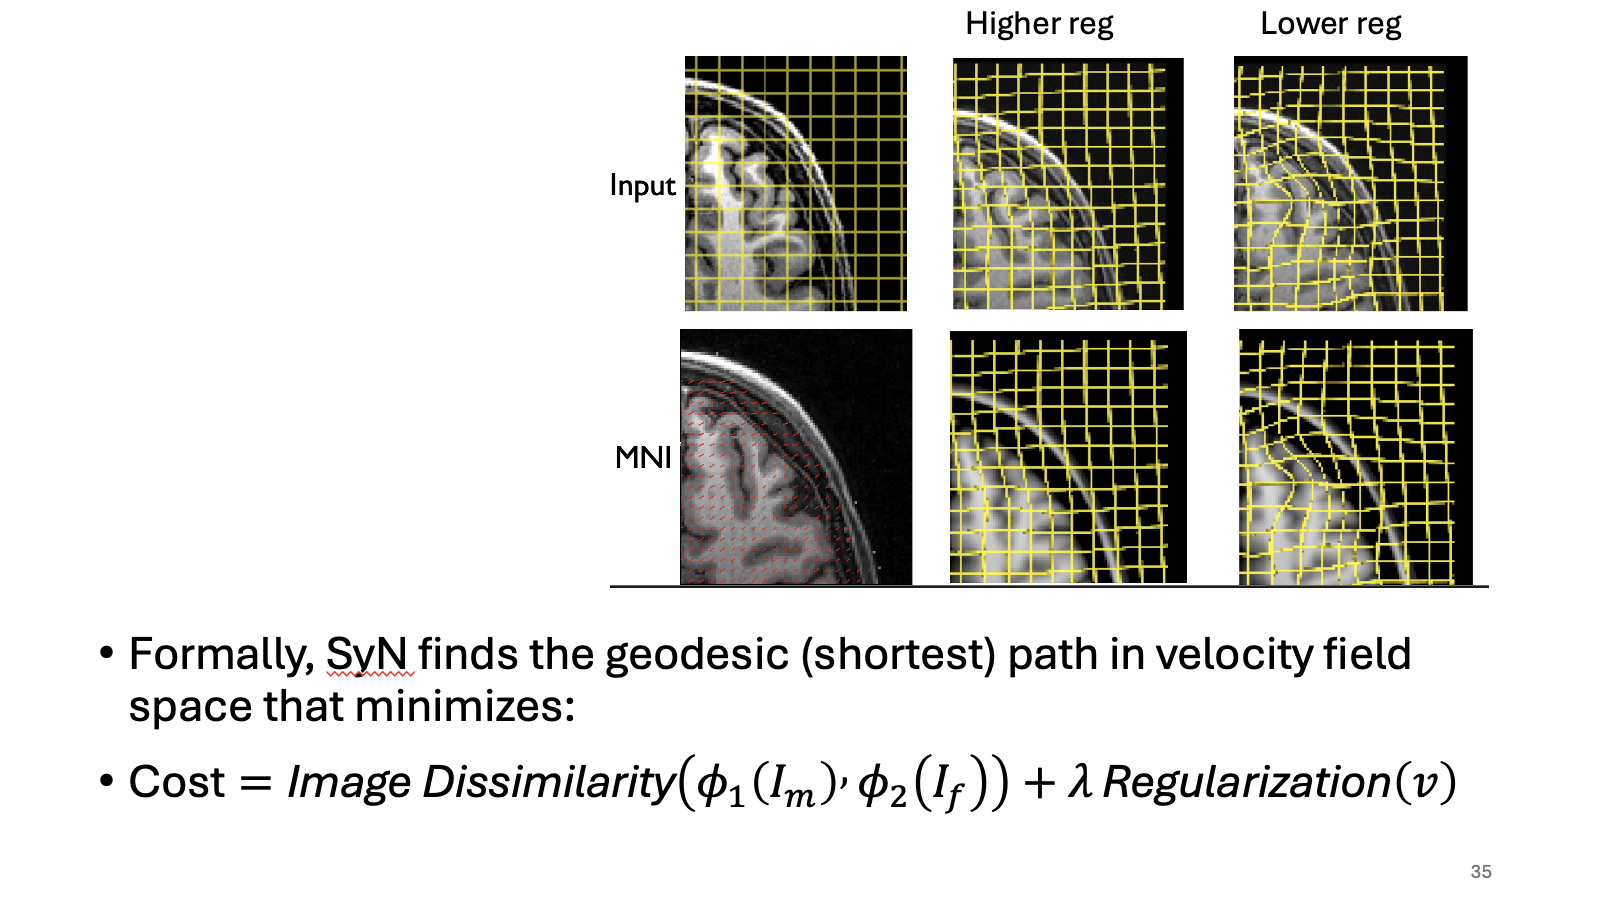

<span style="color: #39b5e6; font-family: 'Georgia', serif; font-size: 22px;">

In Lucys paper:

"Each individual patient contributed electrodes from a limited set of brain locations, which we localized in a common space (MNI152)"

"Separately for each dataset, for each voxel in the 4 mm3 voxel MNI152 brain, we computed the proportion of electrodes in the dataset that were contained within a 20 MNI unit radius sphere centered on that voxel."

"To test whether this held more generally across the entire brain, for each dataset we computed the electrode placement density for each electrode from each patient (using the proportion of other patients’ electrodes within 20 MNI units of the given electrode)."

They don’t treat electrodes as point samples.

</span>

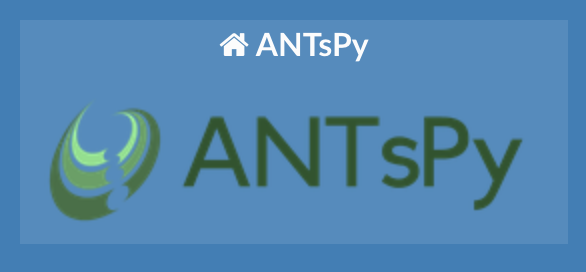

https://antspy.readthedocs.io/en/latest/registration.html#ants.registration

<span style="color: #39e65f; font-family: 'Georgia', serif; font-size: 22px;">

ANTs – Advanced Normalization Tools

SyN = Symmetric Normalization

-   a diffeomorphic non-linear image registration algorithm.

It is a mathematically constrained optimization process that estimates a smooth, invertible deformation field between two images.

The unknowns:

- Affine matrix 

- Translation 

- Velocity field 


Optimized via gradient descent, and a cost function.

</span>

- Load .nii.gz/.nii images using AntsPy and SITK
- Get basic information
- Get numpy representation
- Plot MRI images

In [2]:
%matplotlib inline

# import os
from helpers import *

import ants
import SimpleITK as sitk

print(f'AntsPy version = {ants.__version__}')
print(f'SimpleITK version = {sitk.__version__}')

AntsPy version = 0.5.4
SimpleITK version = 2.4.0


In [3]:
# image path

raw_img_path = "/Users/rustin/Documents/Big Data 567/faces_basic/brains/aa/aa_mri.nii"

## Antspy

In [4]:
# Load .nii.gz/.nii images using AntsPy

raw_img_ants = ants.image_read(raw_img_path)

print(raw_img_ants)

ANTsImage (RPI)
	 Pixel Type : float (float32)
	 Components : 1
	 Dimensions : (256, 256, 124)
	 Spacing    : (1.0156, 1.0156, 1.5)
	 Origin     : (-129.492, 89.4911, -73.1282)
	 Direction  : [ 1.  0.  0.  0. -1.  0.  0.  0.  1.]



### convert to numpy array

In [5]:
raw_img_ants_arr = raw_img_ants.numpy()
raw_img_ants_arr.shape

(256, 256, 124)

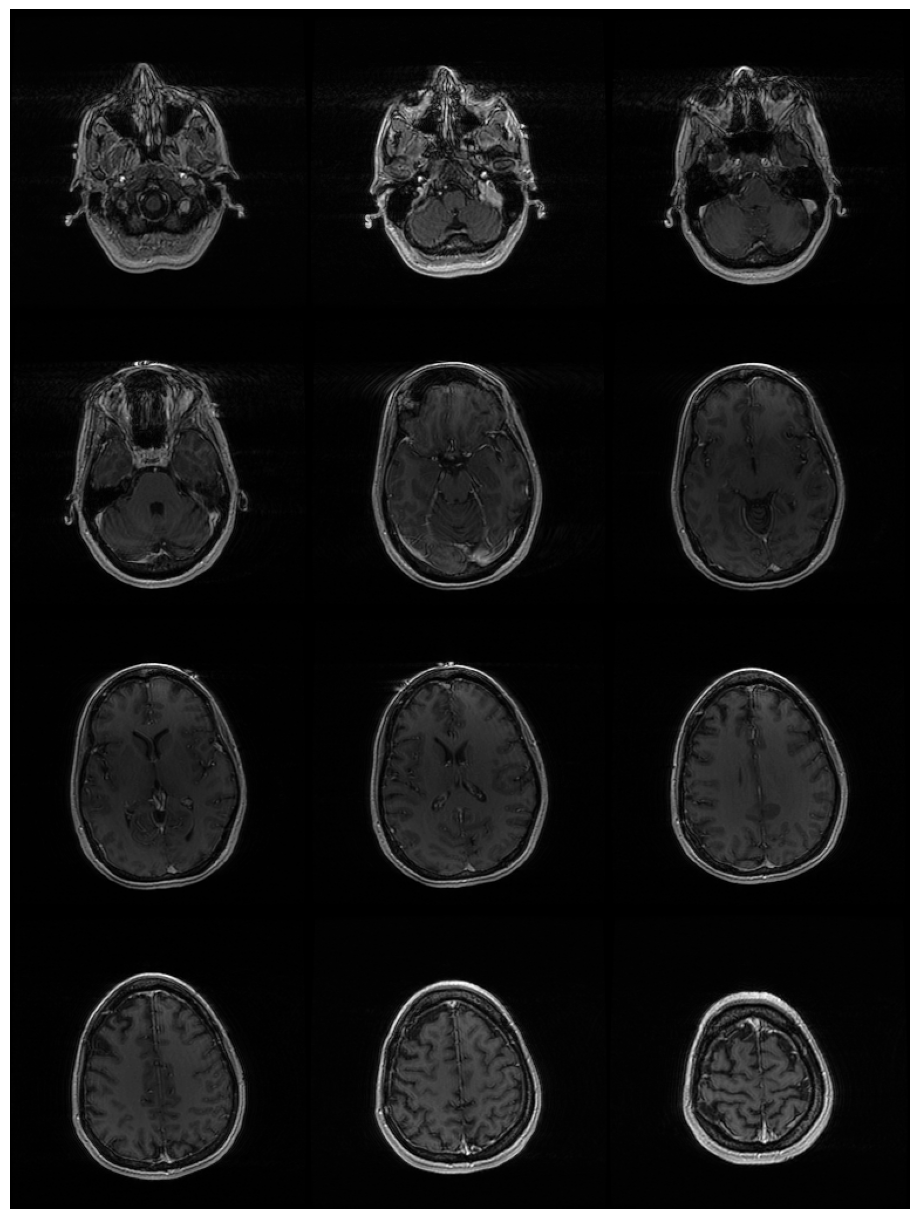

In [6]:
ants.plot(raw_img_ants, figsize=3, axis=2) # can play with axis here

In [7]:
explore_3D_array(raw_img_ants_arr)

# AntsPy orders Z,Y,X

interactive(children=(IntSlider(value=127, description='SLICE', max=255), Output()), _dom_classes=('widget-int…

## Simple ITK

In [8]:
raw_img_sitk = sitk.ReadImage(raw_img_path, sitk.sitkFloat32)

In [9]:
# show the spacing and origin
show_sitk_img_info(raw_img_sitk) # notice the spacing

 Pixel Type : 32-bit float
 Dimensions : (256, 256, 124)
 Spacing : (1.0156199932098389, 1.0156199932098389, 1.5)
 Origin : (-129.49200439453125, 89.49109649658203, -73.1281967163086)
 Direction : (1.0, 0.0, 0.0, 0.0, -1.0, 0.0, 0.0, 0.0, 1.0)


### convert to numpy array

In [10]:
raw_img_sitk_arr = sitk.GetArrayFromImage(raw_img_sitk)
raw_img_sitk_arr.shape 

(124, 256, 256)

In [11]:
explore_3D_array(raw_img_sitk_arr)

# Simple ITK orders X,Y,Z

interactive(children=(IntSlider(value=61, description='SLICE', max=123), Output()), _dom_classes=('widget-inte…

# AntsPy Registration

In [12]:
# download the mni
#ants.get_ants_data('mni')

raw_img_ants = ants.image_read(ants.get_ants_data('mni'))

print(raw_img_ants)

ANTsImage (RPI)
	 Pixel Type : float (float32)
	 Components : 1
	 Dimensions : (182, 218, 182)
	 Spacing    : (1.0, 1.0, 1.0)
	 Origin     : (-90.0, 126.0, -72.0)
	 Direction  : [ 1.  0.  0.  0. -1.  0.  0.  0.  1.]



In [13]:
# load image

raw_img_ants = ants.image_read(raw_img_path, reorient='IAL')

In [14]:
# load template image

template_img_path = "/Users/rustin/Documents/Neuroscience/brAInLab/MRI-preprocessing-techniques/assets/templates/mni_icbm152_t1_tal_nlin_sym_09a.nii"
template_img_ants = ants.image_read(template_img_path, reorient='IAL')

explore_3D_array(arr = template_img_ants.numpy())

interactive(children=(IntSlider(value=94, description='SLICE', max=188), Output()), _dom_classes=('widget-inte…

In [15]:
print('\t\tRAW IMG')
print(raw_img_ants)

print('\t\tTEMPLATE IMG')
print(template_img_ants)

		RAW IMG
ANTsImage (IAL)
	 Pixel Type : float (float32)
	 Components : 1
	 Dimensions : (124, 256, 256)
	 Spacing    : (1.5, 1.0156, 1.0156)
	 Origin     : (129.4911, -169.492, -73.1282)
	 Direction  : [ 0.  0. -1.  0.  1.  0.  1.  0.  0.]

		TEMPLATE IMG
ANTsImage (IAL)
	 Pixel Type : float (float32)
	 Components : 1
	 Dimensions : (189, 233, 197)
	 Spacing    : (1.0, 1.0, 1.0)
	 Origin     : (98.0, -98.0, -72.0)
	 Direction  : [ 0.  0. -1.  0.  1.  0.  1.  0.  0.]



In [16]:
# run the transformation

transformation = ants.registration(
    fixed=template_img_ants,
    moving=raw_img_ants, 
    type_of_transform='SyN',
    verbose=True
)

antsRegistration -d 3 -r [0x372705c48,0x372704268,1] -m mattes[0x372705c48,0x372704268,1,32,regular,0.2] -t Affine[0.25] -c 2100x1200x1200x0 -s 3x2x1x0 -f 4x2x2x1 -x [NA,NA] -m mattes[0x372705c48,0x372704268,1,32] -t SyN[0.200000,3.000000,0.000000] -c [40x20x0,1e-7,8] -s 2x1x0 -f 4x2x1 -u 1 -z 1 -o [/var/folders/qg/c8w4qkrj3_zdz2zqc5_3lpnw0000gn/T/tmpzvqyyt1y,0x372704ac8,0x3727065c8] -x [NA,NA] --float 1 --write-composite-transform 0 -v 1
All_Command_lines_OK
Using single precision for computations.
The composite transform comprises the following transforms (in order): 
  1. Center of mass alignment using fixed image: 0x372705c48 and moving image: 0x372704268 (type = Euler3DTransform)
  Reading mask(s).
    Registration stage 0
      No fixed mask
      No moving mask
    Registration stage 1
      No fixed mask
      No moving mask
  number of levels = 4
  number of levels = 3
  fixed image: 0x372705c48
  moving image: 0x372704268
  fixed image: 0x372705c48
  moving image: 0x372704268

In [17]:
print(transformation)

{'warpedmovout': ANTsImage (IAL)
	 Pixel Type : float (float32)
	 Components : 1
	 Dimensions : (189, 233, 197)
	 Spacing    : (1.0, 1.0, 1.0)
	 Origin     : (98.0, -98.0, -72.0)
	 Direction  : [ 0.  0. -1.  0.  1.  0.  1.  0.  0.]
, 'warpedfixout': ANTsImage (IAL)
	 Pixel Type : float (float32)
	 Components : 1
	 Dimensions : (124, 256, 256)
	 Spacing    : (1.5, 1.0156, 1.0156)
	 Origin     : (129.4911, -169.492, -73.1282)
	 Direction  : [ 0.  0. -1.  0.  1.  0.  1.  0.  0.]
, 'fwdtransforms': ['/var/folders/qg/c8w4qkrj3_zdz2zqc5_3lpnw0000gn/T/tmpzvqyyt1y1Warp.nii.gz', '/var/folders/qg/c8w4qkrj3_zdz2zqc5_3lpnw0000gn/T/tmpzvqyyt1y0GenericAffine.mat'], 'invtransforms': ['/var/folders/qg/c8w4qkrj3_zdz2zqc5_3lpnw0000gn/T/tmpzvqyyt1y0GenericAffine.mat', '/var/folders/qg/c8w4qkrj3_zdz2zqc5_3lpnw0000gn/T/tmpzvqyyt1y1InverseWarp.nii.gz']}


In [18]:
registered_img_ants = transformation['warpedmovout']
# reg["warpedmovout"] = M -> F (moving image mapped into fixed space)
#reg["warpedfixout"] = F -> M (fixed image mapped into moving space) ... of you wanted that for some reason?
explore_3D_array(arr=registered_img_ants.numpy())

interactive(children=(IntSlider(value=94, description='SLICE', max=188), Output()), _dom_classes=('widget-inte…

In [19]:

#out_folder = "/Users/rustin/Documents/Big Data 567/faces_basic/brains/aa/processed"

out_filename = "/Users/rustin/Documents/Big Data 567/faces_basic/brains/aa/processed/aa_mri_registered.nii"

registered_img_ants.to_file(out_filename)


## If electrodes are in the original moving MRI space, apply the same forward registration transforms to the electrode points.

# method 1:

### take the electrode .mat file and convert it into a panda dataframe


In [20]:
from scipy.io import loadmat, savemat

import pandas as pd


loc_path = "/Users/rustin/Documents/Big Data 567/faces_basic/locs/aa_xslocs.mat"

# reg must come from: ants.registration(fixed=template, moving=subject, ...)
# use transformation["fwdtransforms"] for subject -> template

m = loadmat(loc_path, squeeze_me=True)
locs = np.asarray(m["locs"], dtype=float).reshape(-1, 3)

pts = pd.DataFrame(locs, columns=["x", "y", "z"])
pts_mni_df = ants.apply_transforms_to_points(
    dim=3,
    points=pts,
    transformlist=transformation["fwdtransforms"]
)

pts_mni_df.head

<bound method NDFrame.head of             x           y          z
0   33.987793  -85.268372  12.244060
1   33.574432  -75.435081  11.038677
2   31.313051  -66.405663   8.520993
3   30.119532  -56.261593   6.614491
4   29.657621  -47.859604   3.427988
5   29.268202  -38.942234   1.323027
6   29.337769  -30.286823   1.449118
7   31.001450  -23.898149   5.697466
8   23.943851  -48.239353   7.659812
9   31.540947  -46.239712   1.923052
10  38.243938  -43.054184  -1.346664
11  42.565094  -39.203300   2.193579
12  25.121935  -58.885284  10.835018
13  34.094147  -57.212711   7.228927
14  41.248634  -55.088341   4.724800
15  47.909599  -52.643097   5.980636
16  45.651093  -91.506111  15.069387
17  50.616035  -83.862823  12.977664
18  54.375111  -75.628296  11.217167
19  55.529697  -66.065742  12.475307
20  20.817112 -105.341675  20.902481
21  30.287493 -103.644623  19.021198
22  37.336967 -100.262207  17.174225
23  44.882374  -95.968758  16.993261
24  53.213028  -89.626038  18.526560
25  59.6

## Then convert pandas df to numpy for plotting



In [21]:
locs_mni = pts_mni_df[["x","y","z"]].to_numpy()
locs_mni.shape

(46, 3)

## 2 things,
## - we have to plot it with the side view so we can see the temporal lobe where the electrodes are.
## - we do an inverse transform because the locs are in XYZ and ants uses ZYX

In [ ]:
from scipy.io import loadmat
import numpy as np
import ants

# locs are native-space physical coordinates (mm)
loc_path = "/Users/rustin/Documents/Big Data 567/faces_basic/locs/aa_xslocs.mat"
locs_mm = np.asarray(loadmat(loc_path, squeeze_me=True)["locs"], dtype=float).reshape(-1, 3)

native_mask = (ants.make_points_image(locs_mm, target=raw_img_ants, radius=1).numpy() > 0).astype(np.uint8)
explore_3D_array_with_mask_contour(arr=raw_img_ants.numpy(), mask=native_mask)


interactive(children=(IntSlider(value=127, description='SLICE', max=255), Output()), _dom_classes=('widget-int…

In [ ]:
import pandas as pd

pts_df = pd.DataFrame(locs_mm, columns=["x", "y", "z"])
pts_fixed_df = ants.apply_transforms_to_points(
    dim=3,
    points=pts_df,
    transformlist=transformation["invtransforms"],
    whichtoinvert=[True, False],
)

elec_mask = (
    ants.make_points_image(
        pts_fixed_df[["x", "y", "z"]].to_numpy(),
        target=registered_img_ants,
        radius=1,
    ).numpy() > 0
).astype(np.uint8)

explore_3D_array_with_mask_contour(arr=registered_img_ants.numpy(), mask=elec_mask)


interactive(children=(IntSlider(value=98, description='SLICE', max=196), Output()), _dom_classes=('widget-inte…

In [27]:
from pathlib import Path
import numpy as np

# Save transformed electrode coordinates (fixed/template space, mm) for downstream RBF use
locs_fixed_mm = pts_fixed_df[["x", "y", "z"]].to_numpy(dtype=np.float64)

out_npy = Path("/Users/rustin/Documents/Big Data 567/faces_basic/locs/aa_xslocs_registered_mm.npy")
out_npy.parent.mkdir(parents=True, exist_ok=True)
np.save(out_npy, locs_fixed_mm)

print(f"Saved: {out_npy}")
print(f"shape: {locs_fixed_mm.shape}, dtype: {locs_fixed_mm.dtype}")


Saved: /Users/rustin/Documents/Big Data 567/faces_basic/locs/aa_xslocs_registered_mm.npy
shape: (46, 3), dtype: float64
